# Get boundary of Contiguous United States (CONUS) and administrative information

In [70]:
import helpers as h
import functools
import time
import logging, logging.handlers
import csv
import os
import psutil
import json
from datetime import datetime
import pandas as pd
import geopandas as gpd
from shapely import to_wkt
from shapely.wkt import dumps, loads
from shapely.geometry import Polygon, box, Point
from shapely.geometry.base import BaseGeometry
from shapely.ops import transform
import random
import uuid
import psycopg2
from psycopg2 import sql, extras
import geohash2 as geohash
import itertools
import numpy as np
import pyproj
import multiprocessing as mp
import os
import math

In [50]:
tl = gpd.read_parquet('data/tl_2024_us_county.geo.parquet')

<Axes: >

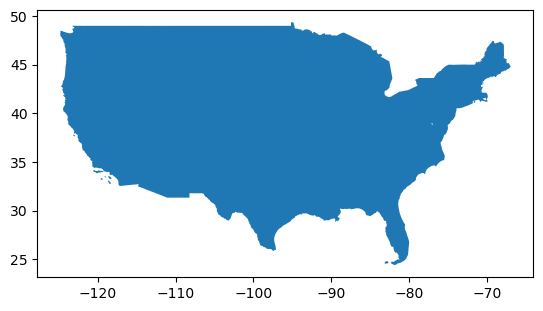

In [51]:
conus_fips = [
    '01', '04', '05', '06', '08', '09', '10', '12', '13', '16', '17', '18', '19',
    '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
    '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48',
    '49', '50', '51', '53', '54', '55', '56'
]

conus = tl[tl['STATEFP'].isin(conus_fips)]
conus_boundary = conus.dissolve()
conus_boundary.to_file('data/conus_boundary.parquet', driver='Parquet')
conus_boundary.plot()

<Axes: >

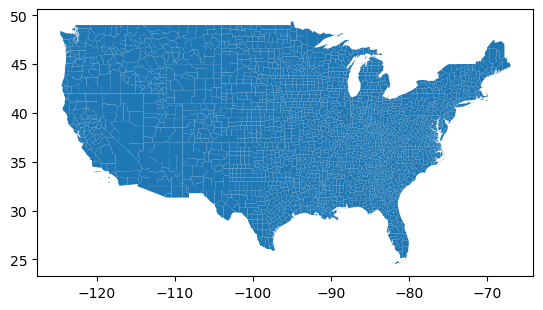

In [52]:
admin_boundaries = gpd.read_file("data/geoBoundaries-USA-ADM2.geojson")  # City, county, state
conus_boundary = conus_boundary.to_crs(epsg=4326)
admin_boundaries.to_crs(conus_boundary.crs)

conus_admin = gpd.overlay(admin_boundaries, conus_boundary, how='intersection')
conus_admin.to_parquet('data/conus_admin.parquet')
conus_admin.plot()

<Axes: >

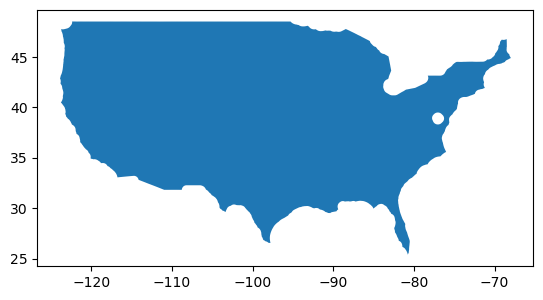

In [53]:
conus_buffer = conus_boundary.to_crs(epsg=5070) # albers equal good for U.S.
conus_buffer['geometry'] = conus_buffer.geometry.buffer(-55000) # 10km buffer
conus_buffer = conus_buffer.to_crs(epsg=4326)
conus_buffer.to_file('data/conus_buffer.parquet', driver='Parquet')
conus_buffer.plot()

Test out function:

Function `generate_random_polygons` executed in 8.1193 sec, CPU: 13.90%, Memory: 150.38MB


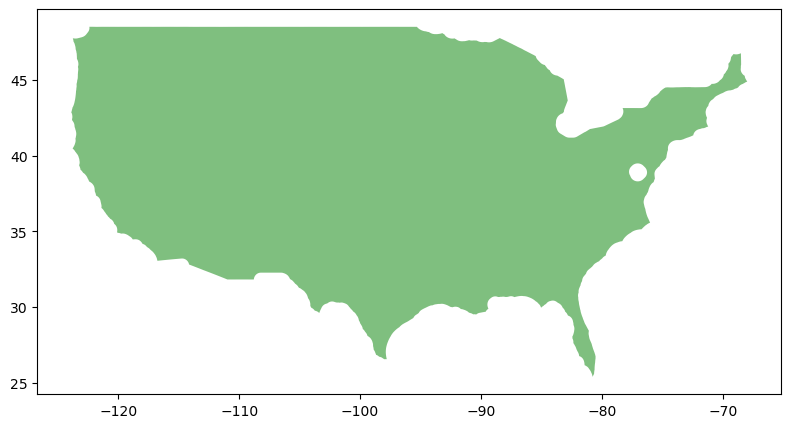

In [54]:
# Run the function
gdf = h.generate_random_polygons(n=10000, us_boundary=conus_buffer, admin_boundaries=conus_admin)

# plot the polygons
fig, ax = plt.subplots(figsize=(10, 5))
conus_buffer.plot(ax=ax, color="green", alpha=0.5)  # CONUS boundary
gdf.plot(ax=ax, color="red", alpha=0.5)  # Random polygons
plt.show()

The polygons are very small, so it's hard to see. Let's confirm that it worked:

In [55]:
gdf.head()

,geometry,id,shapeName,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,area_fips,geohash
5830,"POLYGON ((-81.78181 27.09792, -81.78181 27.098...",68f498e1-4c7a-4a63-aab8-5b303152cfc9,DeSoto,31,039,31039,Cuming,Cuming County,31039,dhvf5j03
3347,"POLYGON ((-81.77020 27.12748, -81.77020 27.128...",7855f010-57ae-4891-97ef-05564f284eb7,DeSoto,31,039,31039,Cuming,Cuming County,31039,dhvf763n
9468,"POLYGON ((-81.85046 27.25483, -81.85046 27.255...",f729223a-1234-41fd-bb0a-6580e6343f09,DeSoto,31,039,31039,Cuming,Cuming County,31039,dhvg13wk
4653,"POLYGON ((-81.85735 27.31534, -81.85735 27.315...",13245f19-021d-44bb-847a-ae45768fe7db,DeSoto,31,039,31039,Cuming,Cuming County,31039,dhvg3k9s
5678,"POLYGON ((-82.16608 27.39216, -82.16608 27.392...",337883ca-c5d6-476d-9d28-9ef792df166d,Manatee,31,039,31039,Cuming,Cuming County,31039,dhvef68u


Confirm area of the first polygon and the average area of the polygons:

In [56]:
area = gdf.to_crs(epsg=3857).loc[1, "geometry"].area
print(f"First polygon area: {area} square meters")

area = gdf.to_crs(epsg=3857).geometry.area
print(f'Mean polygon area:  {area.mean()} square meters')

First polygon area: 4971.963275090753 square meters
Mean polygon area:  4827.544248567984 square meters


These are large polygons, too large for individual buildings, but for our purposes this should work.

## Now, generate polygons for the project

In [ ]:
def generate_random_polygons(n: int, 
                             us_boundary: gpd.GeoDataFrame = gpd.read_file('data/conus_buffer.parquet'), 
                             admin_boundaries: gpd.GeoDataFrame = gpd.read_file('data/conus_admin.parquet'), 
                             precision=7) -> gpd.GeoDataFrame:
    """
    Generate n random polygons fully within the contiguous U.S. (CONUS).
    Ensures all polygons are clipped to the CONUS boundary.

    Params:
        n (int): number of polygons to be generated
        us_boundary: a GeoPandas GeoDataframe of the boundary of the US
        admin_boundaries: a GeoPandas GeoDataframe of the administrative information of the US

    Returns:
        gdf: a GeoPandas GeoDataframe of the polygon layer with administrative and geohash information.
    """
    if us_boundary is None or admin_boundaries is None:
        raise ValueError("Both U.S. boundary and administrative boundaries are required.")

    # Compute bounding box of CONUS
    minx, miny, maxx, maxy = us_boundary.total_bounds

    polygons = []
    ids = []

    while len(polygons) < n:
        # Generate random coordinates within the bounding box
        x1, y1 = random.uniform(minx, maxx), random.uniform(miny, maxy)
        x2, y2 = x1 + random.uniform(0.0001, 0.001), y1 + random.uniform(0.0001, 0.001)
        polygon = box(x1, y1, x2, y2)

        # Ensure the polygon is fully within the CONUS boundary
        if polygon.within(us_boundary.geometry.iloc[0]):  # Checks containment
            polygons.append(polygon)
            ids.append(str(uuid.uuid4()))

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")
    gdf["id"] = ids

    # Clip to CONUS boundary (extra safeguard)
    gdf = gpd.clip(gdf, us_boundary)

    # Compute representative points for spatial join
    gdf["rep_point"] = gdf.geometry.representative_point()

    # Perform spatial join to get city, county, state
    gdf = gdf.sjoin(admin_boundaries, how="left", predicate="within")

    # Compute geohash for location
    gdf["geohash"] = gdf["rep_point"].apply(
        lambda geom: geohash.encode(geom.y, geom.x, precision) if geom else None
    )

    # Drop temporary columns
    gdf = gdf.drop(columns=["rep_point", "index_right"])

    # Drop other columns
    cols_to_keep = [
        'geometry', 
        'id',
        # 'shapeName', 
        # 'STATEFP', 
        # 'COUNTYFP', 
        # 'GEOID', 
        # 'NAME', 
        # 'NAMELSAD', 
        # 'area_fips', 
        'geohash']
    
    # save metadata
    meta_df = gdf[[
        'id',
        'shapeName', 
        'STATEFP', 
        'COUNTYFP', 
        'GEOID', 
        'NAME', 
        'NAMELSAD', 
        'area_fips']]

    # save gdf with dropped cols
    gdf = gdf[cols_to_keep]

    return gdf, meta_df

In [ ]:
prev_month_blobs, prev_meta = generate_random_polygons(n=100000)
curr_month_blobs, curr_meta = generate_random_polygons(n=100000)

In [63]:
prev_month_blobs.head()

,geometry,id,geohash
91,"POLYGON ((-80.73598 26.60317, -80.73598 26.606...",66ccd8b9-6caf-4341-9b44-e255e4c7bffd,dhwx6g
95,"POLYGON ((-82.12919 32.99168, -82.12919 32.996...",d8eb91ac-09db-4603-80b1-33fee546229f,djveen
77,"POLYGON ((-82.29124 33.08630, -82.29124 33.091...",b0a486b2-1491-4cfa-a3c7-8399ae2d1d89,djvkpx
94,"POLYGON ((-89.26863 33.08954, -89.26863 33.091...",bf779ea9-231c-4c99-8349-5df78fa45aee,djbs0x
43,"POLYGON ((-80.25088 34.42616, -80.25088 34.429...",61948ac3-84c1-4946-a520-a92554f5dd9a,dnngvg


In [72]:
area = prev_month_blobs.to_crs(epsg=3857).loc[1, "geometry"].area
print(f"First polygon area: {area} square meters")

area = prev_month_blobs.to_crs(epsg=3857).geometry.area
print(f'Mean polygon area:  {area.mean()} square meters')

side_length = math.sqrt(area.mean())
print(f'Side length of a square polygon given mean area: {side_length} meters')

First polygon area: 11602.199482691298 square meters
Mean polygon area:  4539.108770867484 square meters
Side length of a square polygon given mean area: 67.37290828565651 meters


In [64]:
prev_meta.head()

,id,shapeName,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,area_fips
91,66ccd8b9-6caf-4341-9b44-e255e4c7bffd,Palm Beach,31,039,31039,Cuming,Cuming County,31039
95,d8eb91ac-09db-4603-80b1-33fee546229f,Burke,31,039,31039,Cuming,Cuming County,31039
77,b0a486b2-1491-4cfa-a3c7-8399ae2d1d89,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,bf779ea9-231c-4c99-8349-5df78fa45aee,Winston,31,039,31039,Cuming,Cuming County,31039
43,61948ac3-84c1-4946-a520-a92554f5dd9a,Chesterfield,31,039,31039,Cuming,Cuming County,31039


In [65]:
prev_month_blobs.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 100 entries, 91 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  100 non-null    geometry
 1   id        100 non-null    object  
 2   geohash   100 non-null    object  
dtypes: geometry(1), object(2)
memory usage: 3.1+ KB


Save to .parquet:

In [ ]:
prev_month_blobs.to_file('data/prev_month_blobs.parquet', driver='Parquet')
prev_meta.to_parquet('data/prev_meta.parquet')
curr_month_blobs.to_file('data/curr_month_blobs.parquet', driver='Parquet')
curr_meta.to_parquet('data/curr_meta.parquet')

print('Done.')

Done.


In [66]:
area = prev_month_blobs.to_crs(epsg=3857).loc[1, "geometry"].area
print(f"First polygon area: {area} square meters")

area = prev_month_blobs.to_crs(epsg=3857).geometry.area
print(f'Mean polygon area:  {area.mean()} square meters')

First polygon area: 136578.19688500665 square meters
Mean polygon area:  438399.8068067179 square meters


The average polygon area is slightly more than half the size of Manhattan (0.56 times the size).